In [14]:
#!/usr/bin/env python
# coding: utf-8

# Data Information
train_dataset = "practiceData3Years.nc"
response_var = 'Temperature'
sensor_var = 'Probe'

In [15]:
# Libraries
import xarray
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from scipy.stats import gaussian_kde

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.cuda

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())
print('how many GPUs? = ',torch.cuda.device_count())

False
how many GPUs? =  0


In [16]:
# Load Training Data - here DynaMO chirp-step cycle data
ds = xarray.open_dataset(train_dataset)
df_raw = ds.to_dataframe()
num_rows = df_raw.shape[0]
# num_samples = num_rows
num_samples = 200000
df = df_raw.sample(num_samples, random_state=1)

# Log Transform on temperature
df[response_var] = np.log(df[response_var])
# Normalize and clean data
df_mu = df.mean(axis=0)
df_std = df.std()
df_normalized = (df - df_mu) / df_std
df_inputs = df_normalized.dropna()
df_actual_output = df_inputs.pop(response_var)

c:\Users\darre\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [27]:
# test = pd.read_csv("mu.csv").squeeze().pop("Temperature")
# # test = test.squeeze()
# # type(df.std())
# df_std
# df

from julianToNormal import jd_to_date
# year, month, day = jd_to_date(2455269)
# print(year, month, day)
print(max(df["Julian_Time"]))
print(min(df["Julian_Time"]))
year, month, day = jd_to_date(max(df["Julian_Time"]))
print(year, month, day)
year, month, day = jd_to_date(min(df["Julian_Time"]))
print(year, month, day)


2455928.4625
2455197.5000578705
2012 1 1.9624999999068677
2010 1 1.0000578705221415


In [18]:
# Convert to numpy arrays
df_inputs_arr = np.array(df_inputs)
df_actual_temp_arr = np.array(df_actual_output)
model_input_size = df_inputs_arr.shape[1]

# Convert to tensors
model_inputs = torch.from_numpy(np.float32(df_inputs_arr))
actual_output = torch.from_numpy(np.float32(df_actual_temp_arr))

# Send tensors to GPU
model_inputs = model_inputs.to(device)
actual_output = actual_output.to(device)

In [19]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(model_input_size, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 100)
        self.fc4 = nn.Linear(100, 100)
        self.fc5 = nn.Linear(100, 100)
        self.fc6 = nn.Linear(100, 1)

    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.fc6(x)
        return x

Test Data Error Metrics
RMSE = 1.6790
NRMSE = 0.9454
R2 = 0.9724


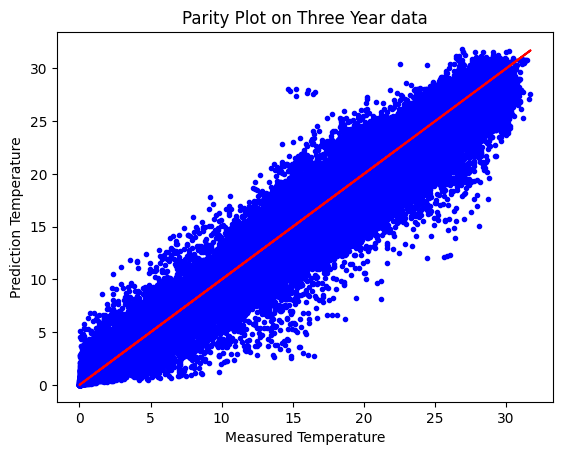

In [20]:
PATH = "OTEC_miniBatchState.pth"
net = Net()
net.load_state_dict(torch.load(PATH))
net.eval()

# Test Model
model_output = net(model_inputs).detach()
model_output.cpu()
# UnNormalizing and undoing log transform
model_output_unstandardized = model_output * df_std[response_var]
model_output_remean = model_output_unstandardized + df_mu[response_var]
model_output_restored = np.exp(model_output_remean.cpu()) # predicted temperature ** OUTPUT

actual_output_unstandardized = actual_output * df_std[response_var]
actual_output_remean = actual_output_unstandardized + df_mu[response_var]
actual_output_restored = np.exp(actual_output_remean) # actual temperature

# Error Metric Calculation
rms = mean_squared_error(actual_output_restored, model_output_restored)
nrms = rms / (df_mu[response_var])
R2 = r2_score(actual_output_restored, model_output_restored)
print("Test Data Error Metrics")
print("RMSE = {:.4f}".format(rms))
print("NRMSE = {:.4f}".format(nrms))
print("R2 = {:.4f}".format(R2))

# xy = np.vstack([actual_output_restored, model_output_restored])
# z = gaussian_kde(xy)(xy)

# # Parity Plot
# fig, ax = plt.subplots(dpi = 100)
# ax.plot(actual_output_restored, model_output_restored, c=z, s=10)
# ax.plot(actual_output_restored,actual_output_restored,'r-')
# ax.set_xlabel('Measured Temperature')
# ax.set_ylabel('Prediction Temperature')
# ax.set_title('Parity Plot on Three Year data')
# plt.savefig('Parity_3_Year_Data.png')

# Parity Plot
fig, ax = plt.subplots(dpi = 100)
ax.plot(actual_output_restored, model_output_restored, 'b.')
ax.plot(actual_output_restored, actual_output_restored, 'r-')
ax.set_xlabel('Measured Temperature')
ax.set_ylabel('Prediction Temperature')
ax.set_title('Parity Plot on Three Year data')
plt.savefig('Parity_3_Year_Data.png')

In [21]:
model_output_restored.numpy()

array([[ 2.351592 ],
       [11.635337 ],
       [19.459816 ],
       ...,
       [12.558249 ],
       [ 0.4759603],
       [22.543652 ]], dtype=float32)